##Machine Translation Using a Seq2Seq Architecture


---
The goal of this colab is to get you more familiar with the Seq2Seq models and their challenges. For this reason, you will be working on machine translation problem where we would have a sentence as input (in english), and the output is gonna be the translated sentence (in french). So just like what happens with Google Translate.


## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np

## Getting the data

We read the english sentences in a dataframe named "english", and the french sentences in a dataframe named "french"

In [ ]:
df_eng = pd.read_csv("en.csv")
df_eng.head()

,"new jersey is sometimes quiet during autumn , and it is snowy in april ."
0,the united states is usually chilly during jul...
1,"california is usually quiet during march , and..."
2,the united states is sometimes mild during jun...
3,"your least liked fruit is the grape , but my l..."
4,"his favorite fruit is the orange , but my favo..."


In [ ]:
df_fr = pd.read_csv("fr.csv")
df_fr.head()

,"new jersey est parfois calme pendant l' automne , et il est neigeux en avril ."
0,les états-unis est généralement froid en juill...
1,"california est généralement calme en mars , et..."
2,"les états-unis est parfois légère en juin , et..."
3,"votre moins aimé fruit est le raisin , mais mo..."
4,"son fruit préféré est l'orange , mais mon préf..."


In [ ]:
print("English sentences: ", len(df_eng))
print("French sentences: ", len(df_fr))

English sentences:  137859
French sentences:  137859


Now let us concatenate the 2 dataframes into one dataframe that we call **df** where one column has the english senetnces and the other has the french sentences

In [ ]:
df = pd.concat([df_eng, df_fr], axis=1)
df.head()

,"new jersey is sometimes quiet during autumn , and it is snowy in april .","new jersey est parfois calme pendant l' automne , et il est neigeux en avril ."
0,the united states is usually chilly during jul...,les états-unis est généralement froid en juill...
1,"california is usually quiet during march , and...","california est généralement calme en mars , et..."
2,the united states is sometimes mild during jun...,"les états-unis est parfois légère en juin , et..."
3,"your least liked fruit is the grape , but my l...","votre moins aimé fruit est le raisin , mais mo..."
4,"his favorite fruit is the orange , but my favo...","son fruit préféré est l'orange , mais mon préf..."


Let's name the columns as **English** and **French** so that we access them easier.

In [ ]:
df.columns = ["English", "French"]
df.head()

,English,French
0,the united states is usually chilly during jul...,les états-unis est généralement froid en juill...
1,"california is usually quiet during march , and...","california est généralement calme en mars , et..."
2,the united states is sometimes mild during jun...,"les états-unis est parfois légère en juin , et..."
3,"your least liked fruit is the grape , but my l...","votre moins aimé fruit est le raisin , mais mo..."
4,"his favorite fruit is the orange , but my favo...","son fruit préféré est l'orange , mais mon préf..."


In [ ]:
print(df["English"][0])
print(df["French"][0])

the united states is usually chilly during july , and it is usually freezing in november .
les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .


##Cleaning Data

The data that we have is almost clean as we can see, we just need to remove the punctuations inside of it.

In [ ]:
import string

df["English"] = df["English"].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
df["French"] = df["French"].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

df.head()

,English,French
0,the united states is usually chilly during jul...,les étatsunis est généralement froid en juille...
1,california is usually quiet during march and ...,california est généralement calme en mars et ...
2,the united states is sometimes mild during jun...,les étatsunis est parfois légère en juin et i...
3,your least liked fruit is the grape but my le...,votre moins aimé fruit est le raisin mais mon...
4,his favorite fruit is the orange but my favor...,son fruit préféré est lorange mais mon préfér...


In [ ]:
print(df["English"][0])
print(df["French"][0])

the united states is usually chilly during july  and it is usually freezing in november 
les étatsunis est généralement froid en juillet  et il gèle habituellement en novembre 


##Exploring the Data

Add a column **ENG Length** to the dataset that shows how many words does a sentence contain, and do the same for french in a column called **FR Length**

In [ ]:
df["ENG Length"] = df["English"].apply(lambda x: len(x.split()))

In [ ]:
df["FR Length"] = df["French"].apply(lambda x: len(x.split()))
df.head()

,English,French,ENG Length,FR Length
0,the united states is usually chilly during jul...,les étatsunis est généralement froid en juille...,15,13
1,california is usually quiet during march and ...,california est généralement calme en mars et ...,13,13
2,the united states is sometimes mild during jun...,les étatsunis est parfois légère en juin et i...,14,13
3,your least liked fruit is the grape but my le...,votre moins aimé fruit est le raisin mais mon...,14,14
4,his favorite fruit is the orange but my favor...,son fruit préféré est lorange mais mon préfér...,12,11


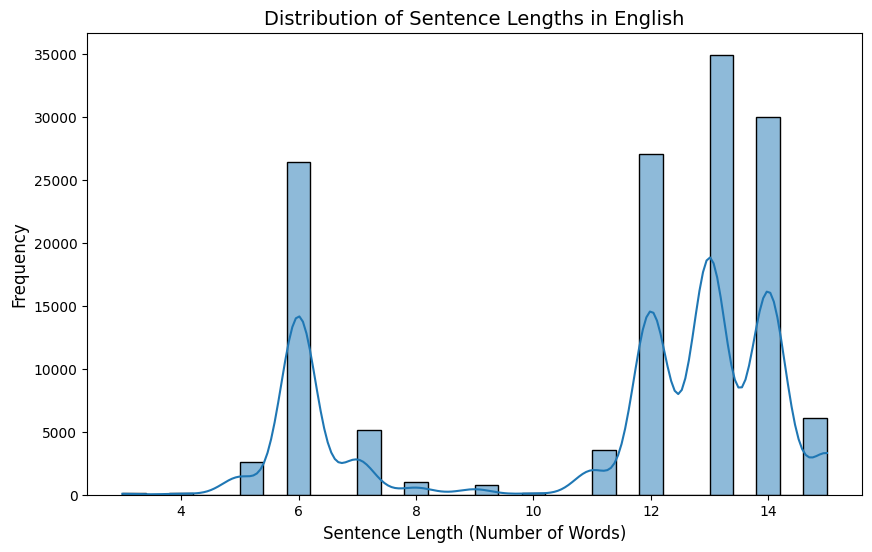

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.histplot(df["ENG Length"], kde = True, bins=30)

plt.title('Distribution of Sentence Lengths in English', fontsize=14)
plt.xlabel('Sentence Length (Number of Words)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.show()

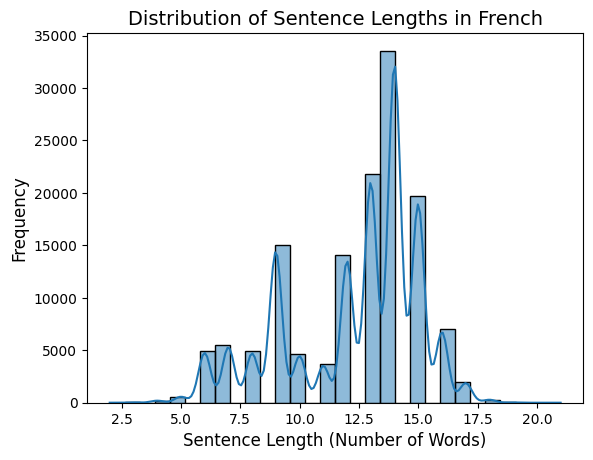

In [ ]:
sns.histplot(df["FR Length"], kde=True, bins=30)

plt.title('Distribution of Sentence Lengths in French', fontsize=14)
plt.xlabel('Sentence Length (Number of Words)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.show()

In [ ]:
max_eng_length = df["ENG Length"].max()
max_fr_length = df["FR Length"].max()

print("Maximum length of an English sentence:", max_eng_length)
print("Maximum length of a French sentence:", max_fr_length)

Maximum length of an English sentence: 15
Maximum length of a French sentence: 21


##Preprocessing the Data

In order for the data to be fed to the model, it has to be tokenized and padded.

####Tokenization

Each language has unique vocabulary, syntax, and punctuation that a single tokenizer might not handle effectively. Using separate tokenizers for each language ensures better tokenization and preprocessing.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(df["English"])
eng_sequences = eng_tokenizer.texts_to_sequences(df["English"])

fr_tokenizer = Tokenizer()
fr_tokenizer.fit_on_texts(df["French"])
fr_sequences = fr_tokenizer.texts_to_sequences(df["French"])

In [ ]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fr_vocab_size = len(fr_tokenizer.word_index) + 1

print("Number of unique words in English:", eng_vocab_size)
print("Number of unique words in French:", fr_vocab_size)

Number of unique words in English: 200
Number of unique words in French: 345


####Padding

The length of the sequences after padding should be a fixed value, typically based on the maximum sequence length in the dataset. This ensures uniform input size for the model.

In [ ]:
#Test Your Zaka
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = max(max_eng_length, max_fr_length)

eng_padded_sequences = pad_sequences(eng_sequences, maxlen=max_length, padding="post")
fr_padded_sequences = pad_sequences(fr_sequences, maxlen=max_length, padding="post")

##Modeling

After preprrocessing the data, we can build our model. Start by building a baseline architecture relying on one directional RNNs, LSTMs, or GRUs. It will be good to lookup how to build Seq2Seq models, there are some new layers that will help you like RepeatVector and TimeDistributed.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, RepeatVector, TimeDistributed, Dense

model = Sequential()

model.add(Embedding(input_dim=eng_vocab_size, output_dim=256, input_length=max_length))
model.add(LSTM(256, return_sequences=False))
model.add(RepeatVector(max_length))

model.add(LSTM(256, return_sequences=True))
model.add(TimeDistributed(Dense(fr_vocab_size, activation='softmax')))

model.build(input_shape=(None, max_length))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

model.fit(eng_padded_sequences, fr_padded_sequences, batch_size=64, epochs=10, validation_split=0.2)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 21, 256)             │          51,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 21, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 21, 256)             │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 21, 345)             │          88,665 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,190,489 (4.54 MB)

 Trainable params: 1,190,489 (4.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 625s 357ms/step - accuracy: 0.5594 - loss: 1.9524 - val_accuracy: 0.7535 - val_loss: 0.8199
Epoch 2/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 623s 358ms/step - accuracy: 0.7812 - loss: 0.7193 - val_accuracy: 0.8620 - val_loss: 0.4512
Epoch 3/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 620s 357ms/step - accuracy: 0.8799 - loss: 0.3943 - val_accuracy: 0.9363 - val_loss: 0.2239
Epoch 4/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 613s 355ms/step - accuracy: 0.9441 - loss: 0.1945 - val_accuracy: 0.9580 - val_loss: 0.1426
Epoch 5/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 625s 357ms/step - accuracy: 0.9611 - loss: 0.1293 - val_accuracy: 0.9659 - val_loss: 0.1122
Epoch 6/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 623s 357ms/step - accuracy: 0.9695 - loss: 0.0991 - val_accuracy: 0.9709 - val_loss: 0.0961
Epoch 7/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 620s 356ms/step - accuracy: 0.9753 - loss: 0.0806 - val_accuracy: 0.9752 - val_loss: 0.0831
Epoch 8/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 622s 356ms/step - ac

In [ ]:
def translate_sentence(input_sentence):
    input_sequence = eng_tokenizer.texts_to_sequences([input_sentence])
    input_sequence = pad_sequences(input_sequence, maxlen=max_length, padding="post")
    predicted_sequence = model.predict(input_sequence)
    predicted_sequence = np.argmax(predicted_sequence, axis=-1)
    translated_sentence = fr_tokenizer.sequences_to_texts(predicted_sequence)[0]
    return translated_sentence

Test the following sentence

In [ ]:
input = "she is driving the truck"

print(translate_sentence(input))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
elle conduit le camion camion brillant


In [ ]:
from tensorflow.keras.layers import Bidirectional

model2 = Sequential()

model2.add(Embedding(input_dim=eng_vocab_size, output_dim=256, input_length=max_length))
model2.add(Bidirectional(LSTM(256, return_sequences=True)))

model2.add(Bidirectional(LSTM(256, return_sequences=True)))

model2.add(TimeDistributed(Dense(fr_vocab_size, activation="softmax")))

model2.build(input_shape=(None, max_length))

In [ ]:
model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model2.summary()

model2.fit(eng_padded_sequences, fr_padded_sequences, batch_size=64, epochs=10, validation_split=0.2)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 21, 256)             │          51,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 21, 512)             │       1,050,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 21, 512)             │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 21, 345)             │         176,985 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,853,721 (10.89 MB)

 Trainable params: 2,853,721 (10.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 1508s 870ms/step - accuracy: 0.6935 - loss: 1.2903 - val_accuracy: 0.9262 - val_loss: 0.2409
Epoch 2/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 1569s 897ms/step - accuracy: 0.9375 - loss: 0.1977 - val_accuracy: 0.9600 - val_loss: 0.1287
Epoch 3/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 1520s 861ms/step - accuracy: 0.9635 - loss: 0.1144 - val_accuracy: 0.9690 - val_loss: 0.0969
Epoch 4/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 1522s 861ms/step - accuracy: 0.9744 - loss: 0.0796 - val_accuracy: 0.9750 - val_loss: 0.0790
Epoch 5/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 1570s 888ms/step - accuracy: 0.9804 - loss: 0.0604 - val_accuracy: 0.9782 - val_loss: 0.0695
Epoch 6/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 1529s 858ms/step - accuracy: 0.9841 - loss: 0.0487 - val_accuracy: 0.9810 - val_loss: 0.0625
Epoch 7/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 1524s 859ms/step - accuracy: 0.9863 - loss: 0.0419 - val_accuracy: 0.9821 - val_loss: 0.0590
Epoch 8/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 1529s 863ms/s

In [ ]:
def translate_sentence2(input_sentence):
    input_sequence = eng_tokenizer.texts_to_sequences([input_sentence])
    input_sequence = pad_sequences(input_sequence, maxlen=max_length, padding="post")
    predicted_sequence = model2.predict(input_sequence)
    predicted_sequence = np.argmax(predicted_sequence, axis=-1)
    translated_sentence = fr_tokenizer.sequences_to_texts(predicted_sequence)[0]
    return translated_sentence

In [ ]:
input = "she is driving the truck"

print(translate_sentence2(input))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
elle conduit le camion


One adjustment could be to add a Dropout layer to prevent overfitting by randomly setting a fraction of input units to zero during training. Another improvement could be to use Bidirectional Attention to capture more context for each timestep in both directions.

You can incorporate pretrained embeddings like GloVe or FastText for better word representations and apply attention mechanisms to focus on relevant parts of the input sequence. Additionally, using learning rate schedulers and fine-tuning hyperparameters can further optimize the model's performance.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed, Bidirectional, Attention

input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=eng_vocab_size, output_dim=256, input_length=max_length)(input_layer)

lstm1 = Bidirectional(LSTM(256, return_sequences=True))(embedding_layer)
lstm2 = Bidirectional(LSTM(256, return_sequences=True))(lstm1)

attention_output = Attention()([lstm2, lstm2])

output_layer = TimeDistributed(Dense(fr_vocab_size, activation="softmax"))(attention_output)

model3 = Model(inputs=input_layer, outputs=output_layer)
model3.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model3.summary()

model3.fit(eng_padded_sequences, fr_padded_sequences, batch_size=64, epochs=10, validation_split=0.2)

def translate_sentence3(input_sentence):
    input_sequence = eng_tokenizer.texts_to_sequences([input_sentence])
    input_sequence = pad_sequences(input_sequence, maxlen=max_length, padding="post")
    predicted_sequence = model3.predict(input_sequence)
    predicted_sequence = np.argmax(predicted_sequence, axis=-1)
    translated_sentence = fr_tokenizer.sequences_to_texts(predicted_sequence)[0]
    return translated_sentence

input_sentence = "she is driving the truck"
print(translate_sentence3(input_sentence))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 21)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 21, 256)        │         51,200 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 21, 512)        │      1,050,624 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 21, 512)        │      1,574,912 │ bidirectional[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 21, 512)        │              0 │ bidirectional_1[0][0], │
│                           │                        │                │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, 21, 345)        │        176,985 │ attention[0][0]        │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,853,721 (10.89 MB)

 Trainable params: 2,853,721 (10.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 1658s 951ms/step - accuracy: 0.6742 - loss: 1.3925 - val_accuracy: 0.9224 - val_loss: 0.2493
Epoch 2/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 1554s 901ms/step - accuracy: 0.9349 - loss: 0.2061 - val_accuracy: 0.9614 - val_loss: 0.1215
Epoch 3/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 1584s 902ms/step - accuracy: 0.9640 - loss: 0.1121 - val_accuracy: 0.9713 - val_loss: 0.0918
Epoch 4/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 1588s 906ms/step - accuracy: 0.9755 - loss: 0.0752 - val_accuracy: 0.9762 - val_loss: 0.0764
Epoch 5/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 1570s 899ms/step - accuracy: 0.9813 - loss: 0.0578 - val_accuracy: 0.9795 - val_loss: 0.0654
Epoch 6/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 1584s 901ms/step - accuracy: 0.9842 - loss: 0.0477 - val_accuracy: 0.9813 - val_loss: 0.0614
Epoch 7/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 1599s 927ms/step - accuracy: 0.9866 - loss: 0.0407 - val_accuracy: 0.9826 - val_loss: 0.0567
Epoch 8/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 1592s 898ms/s